In [3]:
# Predictive Maintenance for Wind Turbines
# Using Supervised and Unsupervised Learning
# Goal: Predict turbine failures early and provide actionable insights
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Loading datasets
event_info = pd.read_csv("/content/comma_event_info.csv")
turbine_55 = pd.read_csv("/content/comma_55.csv")
turbine_81 = pd.read_csv("/content/comma_81.csv")

In [ ]:
print("Event info shape:", event_info.shape)
print("Turbine 55 shape:", turbine_55.shape)
print("Turbine 81 shape:", turbine_81.shape)

Event info shape: (58, 7)
Turbine 55 shape: (55753, 957)
Turbine 81 shape: (53932, 957)


In [ ]:
print("Columns in event_info.csv:")
print(event_info.columns)

Columns in event_info.csv:
Index(['event_id', 'event_label', 'event_start', 'event_start_id', 'event_end',
       'event_end_id', 'event_description'],
      dtype='object')


In [ ]:
print(turbine_55.columns)
print(turbine_81.columns)


Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_0_max', 'sensor_0_min', 'sensor_0_std',
       'sensor_1_avg',
       ...
       'wind_speed_236_min', 'wind_speed_236_std', 'wind_speed_235_avg',
       'wind_speed_235_max', 'wind_speed_235_min', 'wind_speed_235_std',
       'wind_speed_237_avg', 'wind_speed_237_max', 'wind_speed_237_min',
       'wind_speed_237_std'],
      dtype='object', length=957)
Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_0_max', 'sensor_0_min', 'sensor_0_std',
       'sensor_1_avg',
       ...
       'wind_speed_236_min', 'wind_speed_236_std', 'wind_speed_235_avg',
       'wind_speed_235_max', 'wind_speed_235_min', 'wind_speed_235_std',
       'wind_speed_237_avg', 'wind_speed_237_max', 'wind_speed_237_min',
       'wind_speed_237_std'],
      dtype='object', length=957)


In [ ]:
#Converted timestamps to datetime
turbine_55['time_stamp'] = pd.to_datetime(turbine_55['time_stamp'])
turbine_81['time_stamp'] = pd.to_datetime(turbine_81['time_stamp'])
event_info['event_start'] = pd.to_datetime(event_info['event_start'])
event_info['event_end'] = pd.to_datetime(event_info['event_end'])

In [ ]:
#Labeling failure events in turbine datasets
# Creating a 'label' column: 0 = normal, 1 = failure
turbine_55['label'] = 0
turbine_81['label'] = 0

In [ ]:
for idx, event in event_info.iterrows():
  # Labeling turbine 55 if asset_id matches
    turbine_55.loc[
        (turbine_55['asset_id'] == 55) &
        (turbine_55['time_stamp'] >= event['event_start']) &
        (turbine_55['time_stamp'] <= event['event_end']),
        'label'
    ] = 1

    # Labeling turbine 81 if asset_id matches
    turbine_81.loc[
        (turbine_81['asset_id'] == 81) &
        (turbine_81['time_stamp'] >= event['event_start']) &
        (turbine_81['time_stamp'] <= event['event_end']),
        'label'
    ] = 1

In [ ]:
#  Merging datasets
df = pd.concat([turbine_55, turbine_81], axis=0).reset_index(drop=True)

In [ ]:
# Basic preprocessing
# Drop non-numeric columns except 'label'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Ensuring 'label' is included and is a single column
if 'label' in df.columns:
    numeric_cols.append('label')
    numeric_cols = list(dict.fromkeys(numeric_cols)) # Remove duplicates if any

# Including the 'time_stamp' column
if 'time_stamp' in df.columns:
    numeric_cols.append('time_stamp')
    numeric_cols = list(dict.fromkeys(numeric_cols))


df = df[numeric_cols]

In [ ]:
# Filling missing values
df = df.fillna(df.mean())

In [ ]:
# Separating features and labels
X = df.drop('label', axis=1)

# Fixing labels to be 1D
y = df['label'].values   # ensures 1D array
y = y.astype(int)        # just in case

In [ ]:
# Scaling features and split train/test

# Keeping only numeric features for scaling
X_numeric = X.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Saving numeric columns list for later reference
numeric_feature_names = X_numeric.columns.tolist()

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
# Including indices for mapping back
train_idx, idx_test = train_test_split(
    df.index, test_size=0.3, random_state=42, stratify=y
)

X_train, X_test = X_scaled[train_idx], X_scaled[idx_test]
y_train, y_test = y[train_idx], y[idx_test]


In [ ]:
# Supervised Learning: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Use the existing training set
y_pred = rf.predict(X_test)


In [ ]:
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32906

    accuracy                           1.00     32906
   macro avg       1.00      1.00      1.00     32906
weighted avg       1.00      1.00      1.00     32906



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


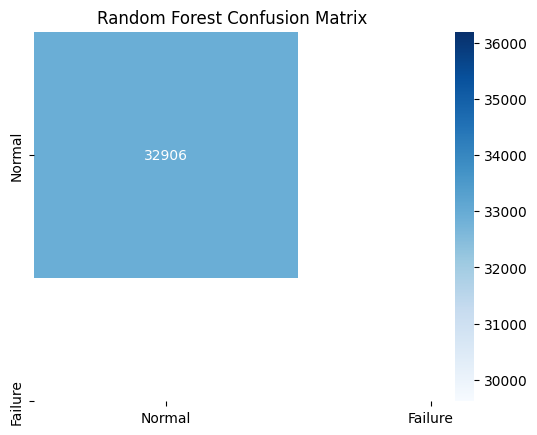

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Failure"],
            yticklabels=["Normal", "Failure"])
plt.title("Random Forest Confusion Matrix")
plt.show()

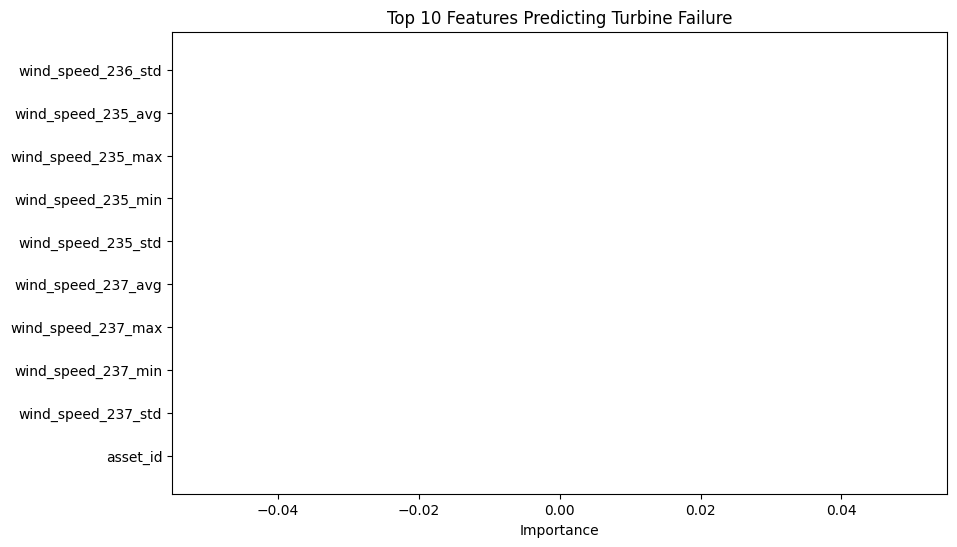

Interpretation: Sensors with higher importance are strong indicators of potential turbine failures. If these sensors rise/fall beyond normal ranges, operators should inspect the turbine.


In [ ]:

# Customer Interpretations / Insights

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx[:10]], importances[sorted_idx[:10]])
plt.xlabel("Importance")
plt.title("Top 10 Features Predicting Turbine Failure")
plt.show()

print("Interpretation: Sensors with higher importance are strong indicators of potential turbine failures. If these sensors rise/fall beyond normal ranges, operators should inspect the turbine.")

In [ ]:
# Generating user-friendly failure probability report where Using numeric feature names only
X_test_df = pd.DataFrame(X_test, columns=numeric_feature_names)  # numeric_feature_names saved earlier

In [ ]:
# Attaching Turbine ID and timestamp from original df and we have to Make sure to get the correct indices from train_test_split
X_test_df['Turbine ID'] = df.iloc[X_test_df.index]['asset_id'].values
X_test_df['Time'] = df.iloc[X_test_df.index]['time_stamp'].values

In [ ]:
# Predicting failure probabilities safely
proba = rf.predict_proba(X_test)
if proba.shape[1] == 2:
    X_test_df['Failure Probability'] = proba[:,1]   # Both classes exist, take probability of failure (class 1)
else:
    X_test_df['Failure Probability'] = 0.0   # Only class 0 exists, so failure probability is 0

In [ ]:
# Assigning status and suggestions
threshold = 0.5
X_test_df['Status'] = X_test_df['Failure Probability'].apply(lambda x: "⚠️ Risk" if x>0.5 else "✅ Safe")
X_test_df['Suggestion'] = X_test_df['Status'].apply(lambda x: "Check & repair soon" if x=="⚠️ Risk" else "No immediate action")

In [ ]:
print("\n--- User-Friendly Failure Report ---")
print(X_test_df[['Time','Turbine ID','Failure Probability','Status','Suggestion']].head())


--- User-Friendly Failure Report ---
                 Time  Turbine ID  Failure Probability  Status  \
0 2017-10-27 11:30:00          50                  0.0  ✅ Safe   
1 2017-10-27 11:40:00          50                  0.0  ✅ Safe   
2 2017-10-27 11:50:00          50                  0.0  ✅ Safe   
3 2017-10-27 12:00:00          50                  0.0  ✅ Safe   
4 2017-10-27 12:10:00          50                  0.0  ✅ Safe   

            Suggestion  
0  No immediate action  
1  No immediate action  
2  No immediate action  
3  No immediate action  
4  No immediate action  


In [ ]:
# Saving the report
X_test_df.to_csv("turbine_failure_report.csv", index=False)

/tmp/ipython-input-3822821722.py:14: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


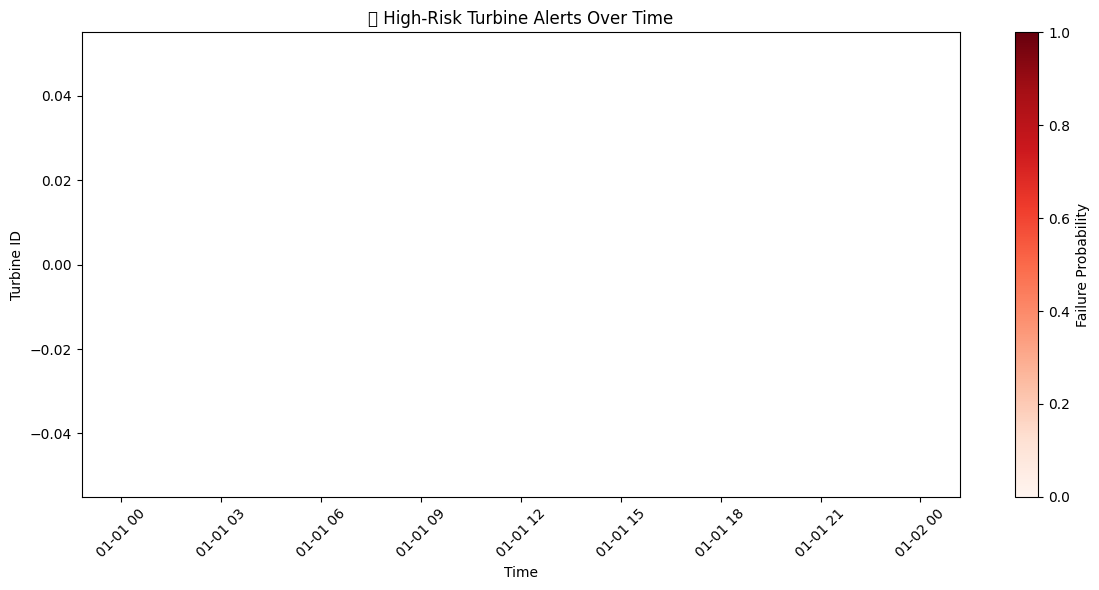

In [ ]:
# Visual Early-Warning Dashboard

plt.figure(figsize=(12,6))   # Highlighting only high-risk alerts
high_risk = X_test_df[X_test_df['Status']=="⚠️ Risk"]
plt.scatter(high_risk['Time'], high_risk['Turbine ID'],
            c=high_risk['Failure Probability'], cmap='Reds', s=50)
plt.colorbar(label='Failure Probability')
plt.xlabel("Time")
plt.ylabel("Turbine ID")
plt.title("🔴 High-Risk Turbine Alerts Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Unsupervised Learning → KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
# Comparing clusters with actual labels
df['Cluster'] = clusters
cross_tab = pd.crosstab(df['label'], df['Cluster'], rownames=['Actual'], colnames=['Cluster'])
print("\n--- KMeans Cluster Cross Tab ---")
print(cross_tab)

In [ ]:
# Visualizing first two features
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap='viridis', s=10)
plt.title("KMeans Clustering (first 2 features)")
plt.show()

In [ ]:
# Adding cluster ID and distance from cluster center as risk score
df['Cluster'] = clusters
distances = kmeans.transform(X_scaled)  # distance to all cluster centers
df['Risk Score'] = np.min(distances, axis=1)  # closer to cluster center = lower risk
# Normalizing risk score 0-1
df['Risk Score'] = (df['Risk Score'] - df['Risk Score'].min()) / (df['Risk Score'].max() - df['Risk Score'].min())

In [ ]:
# Combining supervised & unsupervised risk
combined_df = X_test_df.copy()

# Maping unsupervised risk score from df using idx_test
combined_df['Cluster'] = df.iloc[idx_test]['Cluster'].values
combined_df['Unsupervised Risk Score'] = df.iloc[idx_test]['Risk Score'].values

print("\n--- Combined Supervised & Unsupervised Risk Report ---")
print(combined_df[['Time','Turbine ID','Failure Probability','Status','Cluster','Unsupervised Risk Score']].head())


--- Combined Supervised & Unsupervised Risk Report ---
                 Time  Turbine ID  Failure Probability  Status  Cluster  \
0 2017-10-27 11:30:00          50                  0.0  ✅ Safe        0   
1 2017-10-27 11:40:00          50                  0.0  ✅ Safe        1   
2 2017-10-27 11:50:00          50                  0.0  ✅ Safe        1   
3 2017-10-27 12:00:00          50                  0.0  ✅ Safe        1   
4 2017-10-27 12:10:00          50                  0.0  ✅ Safe        1   

   Unsupervised Risk Score  
0                 0.010388  
1                 0.054017  
2                 0.008938  
3                 0.005482  
4                 0.009737  


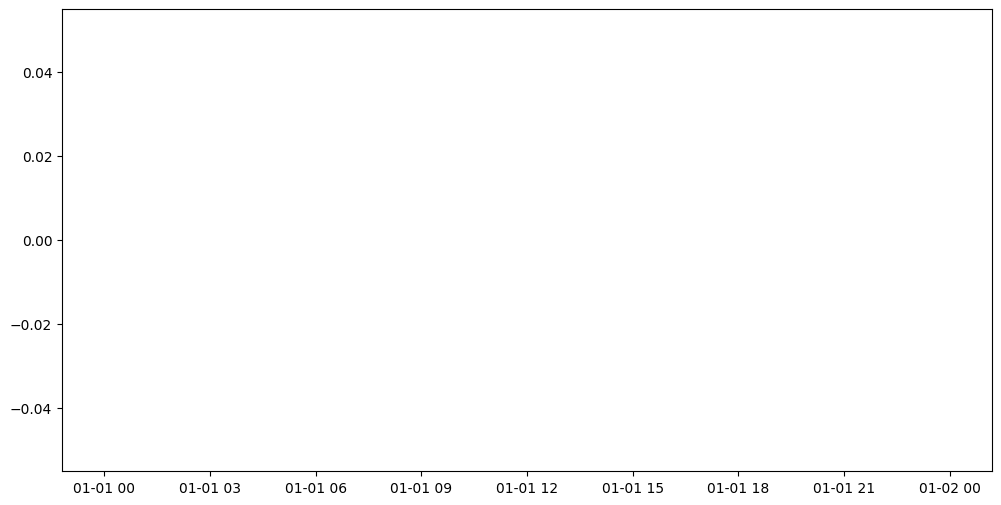

In [ ]:
# Visual Combined Dashboard
plt.figure(figsize=(12,6))

# Highlighting high supervised risk
high_risk = combined_df[combined_df['Status']=="⚠️ Risk"]
plt.scatter(high_risk['Time'], high_risk['Turbine ID'],
            c=high_risk['Failure Probability'], cmap='Reds', s=50, label='Supervised Risk')

/tmp/ipython-input-1311132047.py:12: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


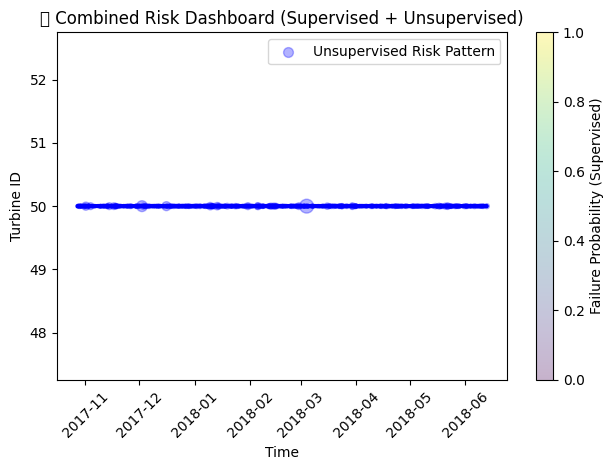

In [ ]:
# Overlay of  unsupervised risk (size = risk score)
plt.scatter(combined_df['Time'], combined_df['Turbine ID'],
            s=combined_df['Unsupervised Risk Score']*100,  # marker size proportional to risk
            c='blue', alpha=0.3, label='Unsupervised Risk Pattern')

plt.colorbar(label='Failure Probability (Supervised)')
plt.xlabel("Time")
plt.ylabel("Turbine ID")
plt.title("🔴 Combined Risk Dashboard (Supervised + Unsupervised)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()